In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import scipy.stats as st
import seaborn as sns

from scipy.interpolate import CubicSpline, UnivariateSpline


In [2]:
exometabolites_folder = Path("../../data/e_coli/")


In [37]:
fn_OD = exometabolites_folder / "{0}_OD.csv".format('ecoli')
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD['ln(OD)'] = np.log(df_OD['OD mean'])

In [38]:
fit = np.polyfit(np.array(df_OD.index[2:9]), np.array(df_OD.loc[2:8, 'ln(OD)']), 1)

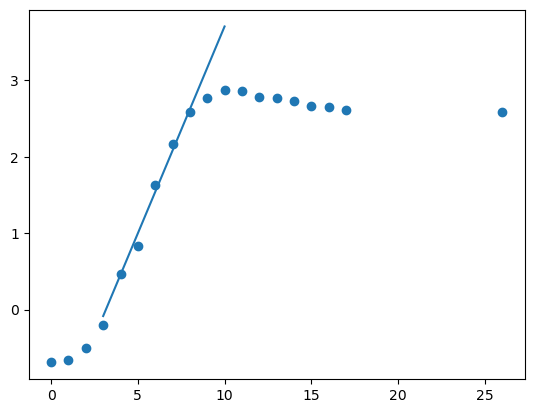

In [39]:
plt.scatter(df_OD.index, df_OD['ln(OD)'])
x = np.linspace(3, 10)
plt.plot(x, fit[1]+fit[0]*x)

In [63]:
fit

array([ 0.54147214, -1.70982706])

In [7]:
from scipy.interpolate import CubicSpline, UnivariateSpline


In [8]:
df_OD

,OD mean,OD std,ln(OD)
Time,,,
0,0.500,NaN,-0.693147
1,0.514,NaN,-0.665532
2,0.608,NaN,-0.497580
3,0.817,NaN,-0.202116
4,1.595,0.049497,0.466874
5,2.295,0.190919,0.830733
6,5.085,0.035355,1.626295
7,8.765,0.106066,2.170767
8,13.300,0.056569,2.587764


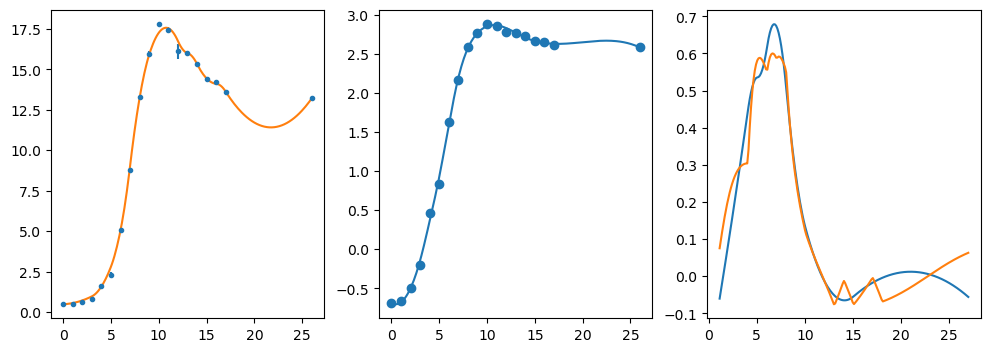

In [68]:
w = 1/df_OD['OD std']
w[np.isnan(w)] = np.min(w)
cs = UnivariateSpline(df_OD.index, df_OD['OD mean'],k = 2, s=0.2, ext =3, w=w*1e-1)
cs_log = UnivariateSpline(df_OD.index, np.log(df_OD['OD mean']), s=0.03,  ext =3)
x = np.linspace(0, 26, 200)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.errorbar(df_OD.index, df_OD['OD mean'], df_OD['OD std'], linestyle='None', marker = '.')
ax1.plot(x, cs(x))

ax2.scatter(df_OD.index, np.log(df_OD['OD mean']))
ax2.plot(x, cs_log(x))

log_cs = cs_log(x)
log_cs2 = np.log(cs(x))
mu = (log_cs[1:]-log_cs[:-1])/(x[1]-x[0])
mu2 = (log_cs2[1:]-log_cs2[:-1])/(x[1]-x[0])
ax3.plot(x[1:], mu)
ax3.plot(x[1:], mu2)

plt.show()

In [46]:
data_folder = Path("../../data/e_coli/")
organism = 'ecoli'
time = 6

In [48]:
# def get_glucose_uptake_rate(data_folder, organism, time, unit = 'gDW'):
"""
Unit can be gDW or OD
"""
exometabolites_folder = Path(data_folder)

# Filenames
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

# Read files as dataframes
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper
glc_per_h = (df_glucose.loc[time+1, 'Glucose mean']-df_glucose.loc[time-1, 'Glucose mean'])/2
glc_per_h_per_od = glc_per_h/df_OD.loc[time, "OD mean"]

Mw_glc = 180.156
glc_mM_per_h_per_od = glc_per_h_per_od/Mw_glc*1000 # Convert from M to mM
# if unit == 'OD':
    # return glc_mM_per_h_per_od
# else:
    # OD to gDW

    # return glc_mM_per_h_per_od/gDW_per_OD[organism]

In [49]:
cs_od = UnivariateSpline(df_OD.index, df_OD['OD mean'] , s=1)
cs_glc = UnivariateSpline(df_glucose.index, df_glucose['Glucose mean'] , s=0.5)
x = np.linspace(0, 25,100)


In [50]:
cs_glc.derivatives(time)[1]/cs_od(time)

-0.46083890641362024

In [51]:
cs_glc(5.01)-cs_glc(5)

-0.014883014154280616

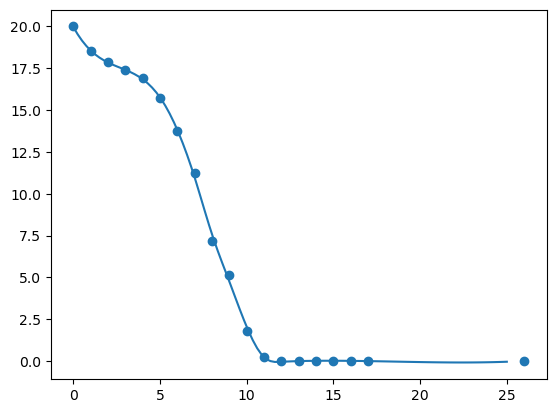

In [52]:
plt.scatter(df_glucose.index, df_glucose['Glucose mean'])
plt.plot(x, cs_glc(x))

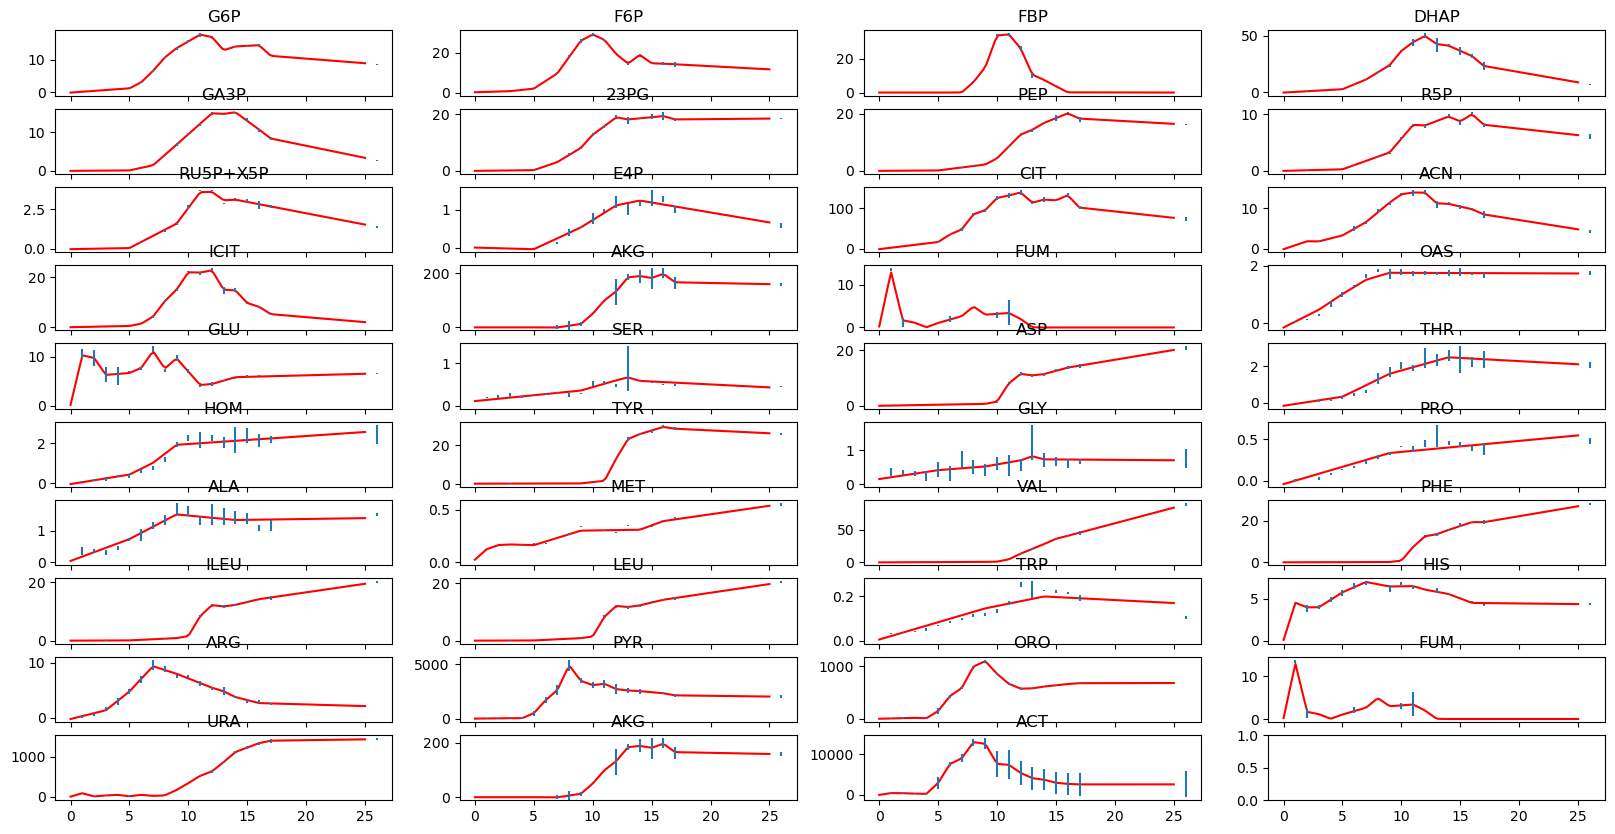

In [70]:
# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]
leakage_list = []
leakage_uncertainty_list = []
cs_od = UnivariateSpline(df_OD.index, df_OD['OD mean'] , s=1)

x = np.linspace(0, 25,100)
fig, axes = plt.subplots(10, 4, figsize = (20, 10), sharex=True)
for n, met_abbrv in enumerate(met_abbreviations):
    i = n//4
    j = (n-4*i)
    # print(met_abbrv)
    met_conc =  df_exometabolites[met_abbrv]
    met_conc[np.isnan(met_conc)]=0
    mean_std = np.nanmean(df_exometabolites_std[met_abbrv])
    cs_met = UnivariateSpline(df_exometabolites.index, met_conc, s = mean_std*2, k = 1)
    leakage_per_h = cs_met.derivatives(time)[1]
    leakage_rate_per_h_per_OD = leakage_per_h / cs_od(time)
    axes[i,j].errorbar(df_exometabolites.index, df_exometabolites[met_abbrv], df_exometabolites_std[met_abbrv], ls = 'none')
    axes[i,j].plot(x, cs_met(x), c = 'r', zorder = 1)
    axes[i,j].set_title(met_abbrv)
plt.show()

In [70]:
df_exometabolites[met_abbrv]

Time
0          NaN
1       444.00
2       415.00
3       328.25
4       243.50
5      2931.50
6      7585.00
7      8945.50
8     12948.50
9     12546.50
10     7551.00
11     7396.50
12     5391.50
13     4096.00
14     3714.00
15     2979.50
16     2707.00
17     2576.00
26     2582.00
Name: ACT, dtype: float64

39

In [8]:
df_glucose

,Glucose mean,Glucose std
Time,,
0,20.0000,0.000000
1,18.5050,24.748737
2,17.8950,17.677670
3,17.3950,9.192388
4,16.9000,21.213203
5,15.7000,43.840620
6,13.7500,8.768124
7,11.2340,5.939697
8,7.1560,2.262742
